In [12]:
import time
import torch as pt
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import display, clear_output, HTML

import seaborn as sns
sns.set_theme()
sns.set(font_scale=1.1, style='ticks')

%matplotlib inline

# Introduction to Hamiltonian Monte Carlo (HMC) via 2D Harmonic Oscillator

### Hamiltonian Dynamics

To learn about how HMC works, we will investigate the familiar motion of a single particle trapped in a 2D Harmonic Oscillator Potential. Some general notation that will be used in this section:

* $n$ denotes the number of dimensions of the configurations space of our system
* $q_{i}$ denotes the $i$-th generalized coordinate, where $i=1,2,\cdots,n$
* $\mathbf{q}$ denotes the set of $n$ generalized coordinates, $q_{1},q_{2},\cdots,q_{n}$
* $p_{i}$ denotes the $i$-th generalized momentum, where $i=1,2,\cdots,n$
* $\mathbf{p}$ denotes the set of $n$ generalized momenta, $p_{1},p_{2},\cdots,p_{n}$
* $L$ represents the Lagrangian of the system
* $K$ represents the kinetic energy
* $U$ represents the potential energy

In general, the corresponding Hamiltonian $H$ for an arbitrary system has the equivalent forms

$$ H(\mathbf{q},\mathbf{p})  = \sum_{i=1}^{n} p_{i} \dot{q}_{i} - L = K(\mathbf{p}) + U(\mathbf{q}) \label{eq:1}\tag{1}$$

where we see that $H$ represents the total energy of our system. For the 2D Harmonic Oscillator, the kinetic energy $K$ has the familiar form

$$ K(\mathbf{p}) = \sum_{i=1}^{n} \dfrac{1}{2}m \dot{q}_{i}^{2} = \sum_{i=1}^{n} \dfrac{p_{i}^{2}}{2m} = \dfrac{\mathbf{p}^{2}}{2m} = \dfrac{1}{2}\mathbf{p}^{T} \mathbf{M}^{-1} \mathbf{p} \label{eq:2}\tag{2} $$

where in general, $\mathbf{M}$ is the mass matrix. The potential energy is proportional to some "spring" constant $k$ which we will usually set to $k=1$

$$ U(\mathbf{q}) = \sum_{i=1}^{n} \dfrac{1}{2}k q_{i}^{2} = \dfrac{1}{2} \mathbf{q}^{T} \mathbf{k} \mathbf{q} \label{eq:3}\tag{3} $$

From Eqs. (1) and (2), we would find that the corresponding Hamiltons equations of motion are

$$ \dot{q}_{i} = \dfrac{\partial H}{\partial p_{i}} = \dfrac{p_{i}}{m} = [\mathbf{M}^{-1}\mathbf{p}]_{i}\qquad \text{and} \qquad \dot{p}_{i} = - \dfrac{\partial H}{\partial q_{i}} = - \dfrac{\partial U}{\partial q_{i}}\qquad [i=1,\cdots,n] \tag{4} $$

Where for the set of generalized coordinates $\mathbf{q}$ and $\mathbf{p}$ we get

$$ \mathbf{\dot{q}} = \mathbf{M}^{-1} \mathbf{p} = - \nabla K(\mathbf{p}) \quad \text{and} \quad \mathbf{\dot{p}} = -\nabla U(\mathbf{q}) \tag{5} $$


### Leapfrog Integration Algorithm

Given some unit measure of time $t$, we can break it up into small time steps $\epsilon$ over $L$ number of steps such that

$$ t = L\epsilon \tag{6} $$

Leapfrog integration is a class of [symplectic integrators](https://en.wikipedia.org/wiki/Symplectic_integrator) that conserves volume (which in this case conserves area in phase space$\?\?$). The algorithm starts by updating the current momentum $\mathbf{p}_{0}$ (at current time $t$) by a HALF a time step and the current position $\mathbf{q}_{0}$ by a FULL time step

$$ 
\begin{align} 
\mathbf{p}_{t + \epsilon/2} &= \mathbf{p}_{0} - \dfrac{\epsilon}{2} \nabla U(\mathbf{q}_{0}) \\[5pt]
\mathbf{q}_{t + \epsilon} &= \mathbf{q}_{0} + \epsilon \nabla K(\mathbf{p}_{t + \epsilon/2})
\end{align}
$$

Then $L-1$ FULL time steps of updating the momentum and position, ending with a final update of the momentum by HALF a time step

$$
\begin{align} 
\mathbf{p}_{t + 3\epsilon/2} &= \mathbf{p}_{t + \epsilon/2} - \epsilon \nabla U(\mathbf{q}_{t + \epsilon}) \\[5pt]
\mathbf{q}_{t + 2\epsilon} &= \mathbf{q}_{t + \epsilon} + \epsilon \nabla K(\mathbf{p}_{t + 3\epsilon/2}) \\[5pt]
&\qquad \vdots \\[5pt]
&\hspace{1pt} (L-2\ \text{more steps}) \\[5pt]
&\qquad \vdots \\[5pt]
\mathbf{q}_{t + L\epsilon} &= \mathbf{q}_{t + (L-1)\epsilon} + \epsilon \nabla K(\mathbf{p}_{t + L\epsilon/2}) \\[5pt]
\mathbf{p}_{t + L\epsilon} &= \mathbf{p}_{t + L\epsilon/2} - \dfrac{\epsilon}{2} \nabla U(\mathbf{q}_{t + L\epsilon})
\end{align}
$$

However, given the position and momentum at the start of the algorithm (which I will now denote as $\mathbf{q}$ and $\mathbf{p}$), how do we decide whether our resulting position and momentum at the end ($\mathbf{q}^{*}$ and $\mathbf{p}^{*}$) are valid?


### Statistical Mechanics

From Statistical mechanics, the canonical distribution tells us the relationship between the probability of a system to be found in some state $q$ corresponding to some energy $E(q)$, is

$$P(q) = \dfrac{1}{Z} e^{-E(q)/\tau} \tag{7}$$

where $Z$ is the normalizing partition function and $\tau = 1/k_{B}T$ is the fundamental temperature of the system that is related to the Boltzmann constant $k_{B}$ and absolute temperature $T$. Since the Hamiltonian is just the total energy of the system, it follows that

$$ P(\mathbf{q},\mathbf{p}) = \dfrac{1}{Z} e^{- H(\mathbf{q},\mathbf{p})/\tau} = \dfrac{1}{Z} e^{-K(\mathbf{p})/\tau} e^{-U(\mathbf{q})/\tau} = \dfrac{1}{Z} P(\mathbf{p})P(\mathbf{q}) \tag{8}$$

Where we see that the joint (canonical) probability distribution for $\mathbf{q}$ and $\mathbf{p}$ factorizes such that we get

$$P(\mathbf{p}) =  e^{-K(\mathbf{p})/\tau} \qquad \text{and} \qquad P(\mathbf{q}) = e^{-U(\mathbf{q})/\tau} \tag{9}$$

Using Eq. (2) for $K(\mathbf{p})$ in Eq. (7) (setting $\tau=1$), we see that this is just a normal distribution (or more specifically, a multivaritate normal distribution with mean centered about zero and covariance matrix $M$)

$$ P(\mathbf{p}) \propto  e^{-\mathbf{p}^{2}/2M}\ \longrightarrow \ \mathcal{N}_{\mathbf{p}}(0,M) \tag{10} $$

$$ P(\mathbf{q}) \propto e^{-U(\mathbf{q})} \propto P(q)\, P(q|\mathcal{D}) \tag{11} $$

Then Eq. (2) equivalently tells us

$$ E(q) = -\tau\ln\big(P(q)\big) - \tau\ln\big(Z\big) $$

and thus, using $P(\mathbf{q},\mathbf{p}) \propto P(\mathbf{p}) P(\mathbf{q})$

$$ H(\mathbf{q},\mathbf{p}) = - \tau \ln\big(P(\mathbf{p})\big) - \tau\ln\big(P(\mathbf{q})\big) - \tau\ln(Z) = - \tau \ln\!\big(\mathcal{N}_{\mathbf{p}}(0,M)\big) - \tau \ln\!\big(P(q)\, P(q|\mathcal{D})\big) - \tau\ln(Z) $$

where we see the last term is the Helmholtz free energy of the system $F$ which, at constant temperature, is minimized at equilibrium

$$ F = - \tau\ln(Z)\ \longrightarrow \ 0\quad (\text{at equilibrium}) $$

Using Eq. (1), we then get the relation

$$ H(\mathbf{q},\mathbf{p}) = K(\mathbf{p}) + U(\mathbf{q}) = - \tau \ln\big(P(\mathbf{p})\big) - \tau\ln\big(P(\mathbf{q})\big) = - \tau \ln\!\big(\mathcal{N}_{\mathbf{p}}(0,M)\big) - \tau \ln\!\big(P(q)\, P(q|\mathcal{D})\big) \tag{12} $$

where we see that

$$
\begin{align}
K(\mathbf{p}) &= - \tau \ln\big(P(\mathbf{p})\big) = - \tau \ln\!\big(\mathcal{N}_{\mathbf{p}}(0,M)\big) \tag{13} \\[5pt]
U(\mathbf{q}) &= - \tau\ln\big(P(\mathbf{q})\big) = - \tau \ln\!\big(P(q)\, P(q|\mathcal{D})\big) \tag{14}
\end{align}
$$

For an ideal isolated system, at any arbitrary points in time $t$, it must be that the total energy of the system is conserved such that

$$ \dfrac{\partial H(\mathbf{q},\mathbf{p})}{\partial t} = 0 \tag{15} $$

Therefore, using Eq. (1), it must also be true that for a real closed (non-ideal) system

$$
\begin{align}
H(\mathbf{q},\mathbf{p}) \approx H(\mathbf{q}^{*},\mathbf{p}^{*})
\ &\longrightarrow \
H(\mathbf{q},\mathbf{p}) - H(\mathbf{q}^{*},\mathbf{p}^{*}) \approx 0 \tag{16} \\[5pt]
K(\mathbf{p}) + U(\mathbf{q}) \approx K(\mathbf{p}^{*}) + U(\mathbf{q}^{*})
\ &\longrightarrow \
K(\mathbf{p}) + U(\mathbf{q}) - K(\mathbf{p}^{*}) - U(\mathbf{q}^{*}) \approx 0 \tag{17}
\end{align}
$$


### Metropolis-Hastings Algorithm

From Eqs. (15) and (16), it is clear that

$$ e^{- H(\mathbf{q}^{*},\mathbf{p}^{*}) + H(\mathbf{q},\mathbf{p})} \rightarrow 1 \qquad \text{as} \qquad - H(\mathbf{q}^{*},\mathbf{p}^{*}) + H(\mathbf{q},\mathbf{p}) \rightarrow 0 $$

Using a step in the [Metroplis-Hastings algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) we define the acceptance ratio $\alpha$ as

$$ \alpha = \text{min}\!\big( 1,\ e^{- H(\mathbf{q}^{*},\mathbf{p}^{*}) + H(\mathbf{q},\mathbf{p})} \big)
\qquad\qquad \text{acceptance ratio} \tag{18}$$

and $\beta$ as 

$$ \beta = \mathcal{N}(0,1) \tag{19} $$

where:

* if $\beta \leq \alpha$, then we accept the proposed $\mathbf{q}^{*}$ and $\mathbf{p}^{*}$ as the current position and momentum, setting $\mathbf{q}_{t+1} = \mathbf{q}^{*}$ and $\mathbf{p}_{t+1} = \mathbf{p}^{*}$
* if $\beta > \alpha$, we reject the proposed $\mathbf{q}^{*}$ and $\mathbf{p}^{*}$ as set $\mathbf{q}_{t+1} = \mathbf{q}$ and $\mathbf{p}_{t+1} = \mathbf{p}$

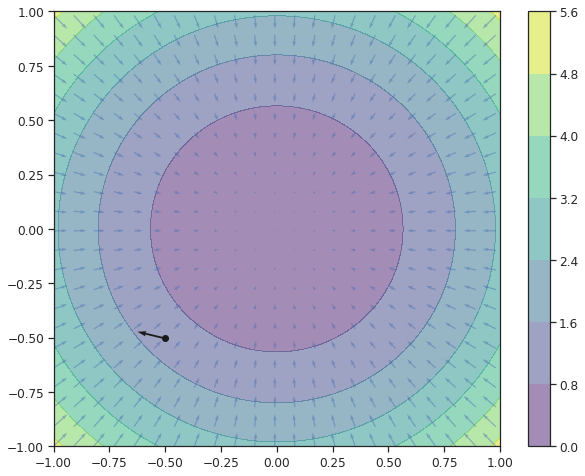

In [19]:
#initial position of particle
q0 = np.array([-0.50, -0.50])

#initial momentum of particle is sampled from a multivariate normal distribution ~N(0,M)
p0 =  np.random.multivariate_normal([0,0], [[1,0],[0,1]])

#mesh for contour plot
dim = 1  #minimum/maximum value of dimensions
rowscols = np.linspace(-dim, dim, 1000)
X, Y = np.meshgrid(rowscols, rowscols)

#kinetic energy function K
K = lambda x, y: 0.5 * (x**2 + y**2)

#potential energy function U
k = 5.0  #scale the strength of the potential
U = lambda x, y: k * 0.5 * (x**2 + y**2)

#gradient of U
def U_grad(x, y):
    q = pt.tensor([x, y], requires_grad=True)
    U = k * 0.5 * (q[0]**2 + q[1]**2)
    U.backward()
    return q.grad.detach().numpy()

#mesh of potential U evaluated at every point in X and Y
U_mesh = X*0
for i in range(len(X[:,0])):
    for j in range(len(Y[0,:])):
        U_mesh[i,j] = k * 0.5 * (rowscols[i]**2 + rowscols[j]**2)

#gradient of U_mesh via nearest neighbor points
dUy, dUx = np.gradient(U_mesh)
#spaces out quiver arrows to be less dense
skip = (slice(None, None, 45), slice(None, None, 45))

#plot potential, particle, and gradient vector field
fig, ax = plt.subplots(figsize=(10,8))
cp = ax.contourf(X, Y, U_mesh, cmap='viridis', alpha=0.5)
fig.colorbar(cp)
ax.plot(q0[0], q0[1], 'o', color='k')
ax.quiver(X[skip], Y[skip], -dUx[skip], -dUy[skip], color='b', alpha=0.5)
ax.quiver(q0[0], q0[1], p0[0], p0[1], color='k', scale=15.0, width=0.004)
plt.xlim([-dim, dim])
plt.ylim([-dim, dim])
plt.show()

In [20]:
min_step = np.random.uniform(0.01, 0.07)
max_step = np.random.uniform(0.07, 0.18)
min_traj = np.random.uniform(1, 18)
max_traj = np.random.uniform(18, 25)

step_size = np.random.uniform(min_step, max_step)
traj_size = int(np.random.uniform(min_traj, max_traj))

print('random step size: {:.6f}'.format(step_size))
print('random trajectory size: {}'.format(traj_size))

random step size: 0.089371
random trajectory size: 17


intial position and momentum: [-0.5 -0.5], [-0.94303949  0.22725667]
position and momentum at dt=1: [-0.57429671 -0.46970569], [-0.83132521  0.33897094]
alpha: 0.9430676232915263
beta: 0.7110803620153235
ACCEPT PROPOSAL


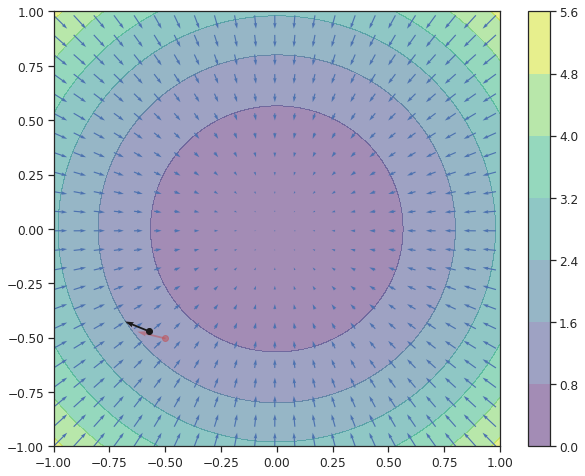

In [21]:
print('intial position and momentum: {}, {}'.format(q0, p0))

p1 = p0 - 0.5 * step_size * U_grad(q0[0], q0[1])
q1 = q0 + step_size * p1

print('position and momentum at dt=1: {}, {}'.format(q1, p1))

alpha = np.min([1, np.exp( - U(q1[0],q1[1]) + U(q0[0],q0[1]) - K(p1[0],p1[1]) + K(p0[0],p0[1]))])
beta = np.random.uniform(0,1)

print('alpha: {}'.format(alpha))
print('beta: {}'.format(beta))

if beta <= alpha:
    print('ACCEPT PROPOSAL')
else:
    print('REJECT PROPOSAL')

#plot potential, particle, and gradient vector field
fig, ax = plt.subplots(figsize=(10,8))
cp = ax.contourf(X, Y, U_mesh, cmap='viridis', alpha=0.5)
fig.colorbar(cp)
ax.plot(q0[0], q0[1], 'o', color='r', alpha=0.5)
ax.quiver(X[skip], Y[skip], -dUx[skip], -dUy[skip], color='b')
ax.quiver(q0[0], q0[1], p0[0], p0[1], color='r', scale=15.0, width=0.004, alpha=0.5)
ax.plot(q1[0], q1[1], 'o', color='k')
ax.quiver(q1[0], q1[1], p1[0], p1[1], color='k', scale=15.0, width=0.004)
plt.xlim([-dim, dim])
plt.ylim([-dim, dim])
plt.show()

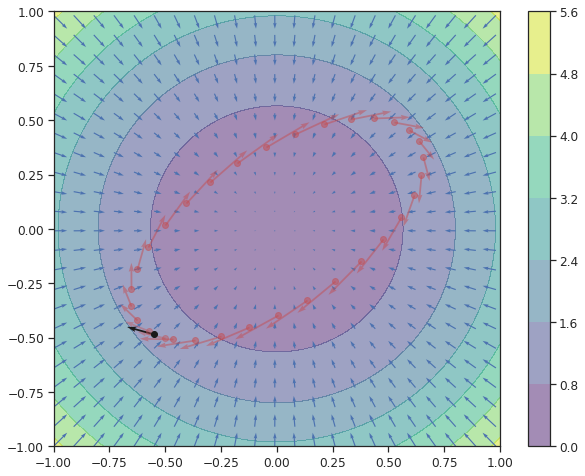

alpha: 0.9295025239660649
beta: 0.5880463997283979
ACCEPT PROPOSAL


In [22]:
p = p1 - step_size * U_grad(q1[0], q1[1])
q = q1 + step_size * p

#plot potential, particle, and gradient vector field
fig, ax = plt.subplots(figsize=(10,8))
cp = ax.contourf(X, Y, U_mesh, cmap='viridis', alpha=0.5)
fig.colorbar(cp)
ax.plot(q0[0], q0[1], 'o', color='r', alpha=0.4)
ax.quiver(X[skip], Y[skip], -dUx[skip], -dUy[skip], color='b')
ax.quiver(q0[0], q0[1], p0[0], p0[1], color='r', scale=15.0, width=0.004, alpha=0.4)
ax.plot(q1[0], q1[1], 'o', color='r', alpha=0.4)
ax.quiver(q1[0], q1[1], p1[0], p1[1], color='r', scale=15.0, width=0.004, alpha=0.4)
for i in range(30):
    ax.plot(q[0], q[1], 'o', color='r', alpha=0.5)
    ax.quiver(q[0], q[1], p[0], p[1], color='r', scale=15.0, width=0.004, alpha=0.5)
    p -= step_size * U_grad(q[0], q[1])
    q += step_size * p
ax.plot(q[0], q[1], 'o', color='k')
ax.quiver(q[0], q[1], p[0], p[1], color='k', scale=15.0, width=0.004)
plt.xlim([-dim, dim])
plt.ylim([-dim, dim])
plt.show()

alpha = np.min([1, np.exp( - U(q[0],q[1]) + U(q0[0],q0[1]) - K(p[0],p[1]) + K(p0[0],p0[1]))])
beta = np.random.uniform(0,1)

print('alpha: {}'.format(alpha))
print('beta: {}'.format(beta))

if beta <= alpha:
    print('ACCEPT PROPOSAL')
else:
    print('REJECT PROPOSAL')

In [23]:
#plot animated potential, particle, and gradient vector field
fig, ax = plt.subplots(figsize=(10,8))
ax.set(xlim=(-dim,dim), ylim=(-dim,dim))

cp = ax.contourf(X, Y, U_mesh, cmap='viridis', alpha=0.5)
fig.colorbar(cp)
ax.quiver(X[skip], Y[skip], -dUx[skip], -dUy[skip], color='b')

ax.plot(q0[0], q0[1], 'o', color='k', alpha=0.3)
ax.quiver(q0[0], q0[1], p0[0], p0[1], color='k', scale=15.0, width=0.004, alpha=0.3)

p = p0 - 0.5 * step_size * U_grad(q0[0], q0[1])
q = q0 + step_size * p

def animate(i, q, p):
    a = min(1, 0.3 + (0.01 * i))
    ax.plot(q[0], q[1], 'o', color='k', alpha=a)
    ax.quiver(q[0], q[1], p[0], p[1], color='r', scale=15.0, width=0.004, alpha=a)
    p -= step_size * U_grad(q[0], q[1])
    q += step_size * p

anim = FuncAnimation(fig, animate, fargs=(q, p), frames=40, blit=False, interval=200)

display(HTML(anim.to_jshtml()))
plt.close()